<a href="https://colab.research.google.com/github/TurboGooseEdu/machine-learning/blob/task-2/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 2. Линейная регрессия, метод градиентного спуска

Выполнил: Коновалов Илья, группа 23.М07-мм

## Задача

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [x] Повторить тоже самое, но используя **кросс-валидацию**.
- [x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [x] (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [x] (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [ ] (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [x] (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# EDA

## Датасет
Используемый [датасет](https://www.kaggle.com/datasets/mirichoi0218/insurance),содержит данные по медецинскому страхованию.

## Описание признаков
- `age`: возраст
- `sex`: пол
- `bmi`: индекс массы тела
- `children`: количество детей
- `smoker`: курящий или нет
- `region`: район проживания (northeast, southeast, southwest, northwest)
- `charges`: медицинские расходы

Целевым признаком будет `charges`

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ml/datasets/insurance.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Проверим количество пропусков в данных

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.describe(include="all")

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


Данное описание говорит нам, что:
- В выборке примерно порвну мужчин и женщин
- Средний возраст составляет 40 лет
- В среднем имеется один ребенок
- 3/4 из претендентов не курящие
- Среднее значение расходов на медобслуживание находится в районе 13000, однако также имеется большой разбос по значению сопоставимый со средним значением - 12000

## Рассмотрим распределение целевого признака

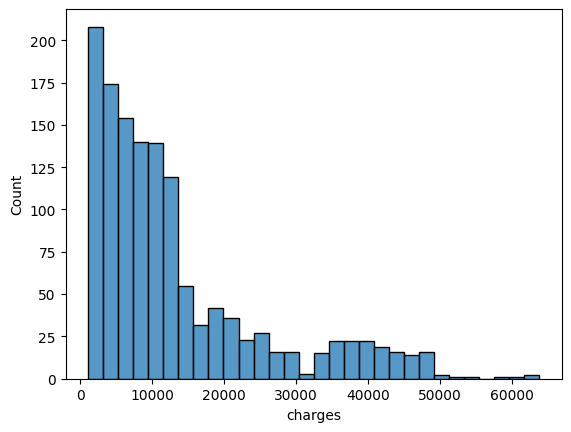

In [6]:
sns.histplot(df, x="charges");

## Рассмотрим траты на медобслуживание в зависимости от пола

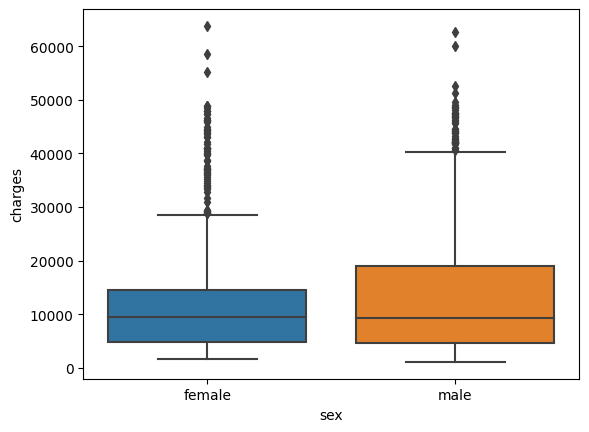

In [7]:
sns.boxplot(df, x="sex", y="charges");

Видно, что для мужчин верхние перцентили находятся выше, чем для женщин, соответственно, расходы тоже выше

## Рассмотрим траты на медобслуживание в зависимости от пола


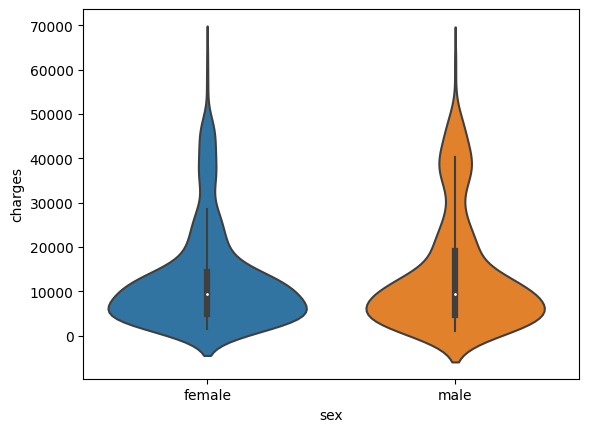

In [8]:
sns.violinplot(x="sex", y="charges", data=df);

Видно, что распределение примерно одинаковое для мужчин и для женщин

## Рассмотрим траты на медобслуживание для курильщиков

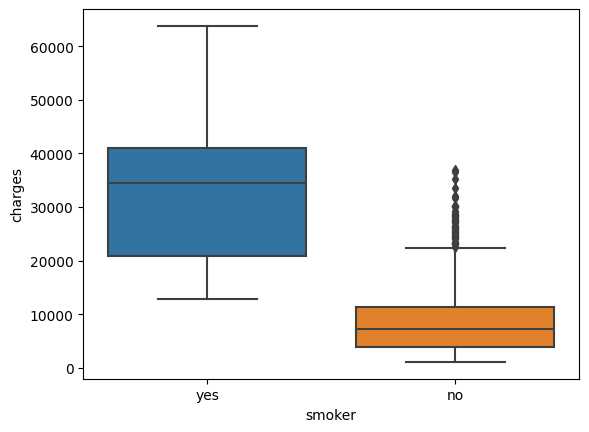

In [9]:
sns.boxplot(df, x="smoker", y="charges");

Видим, что у курильщиков расходы значительно выше

## Рассмотрим траты на медобслуживание в зависимости от региона

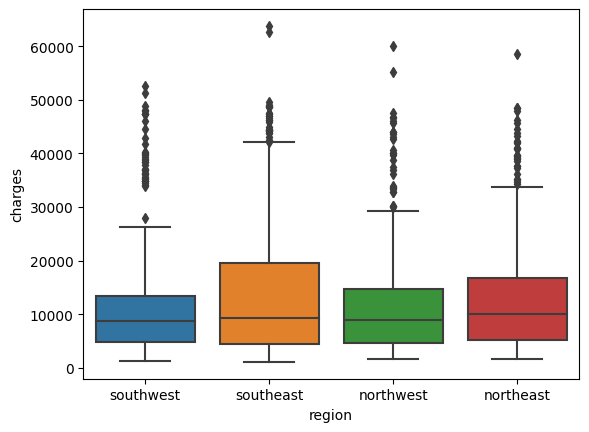

In [10]:
sns.boxplot(df, x="region", y="charges");

Видно, что во всех регионах первый квартиль находится примерно на одинаковом уровне.
В то же время в юго-восточном регионе интерквартильный размах больше, чем в остальных, что, скорее всего, может свидетельствовать о хорошем финансовом благосостоянии жителей данного региона.

## Выполним кодирование категориальных признаков

In [11]:
le = LabelEncoder()

df["sex"] = le.fit_transform(df["sex"])
df["smoker"] = le.fit_transform(df["smoker"])
df["region"] = le.fit_transform(df["region"])

## Рассмотрим корреляцию полученных признаков

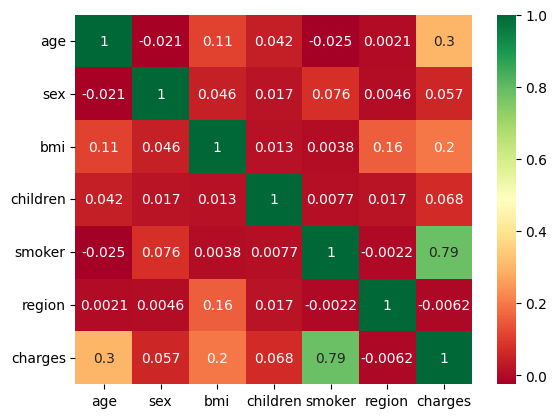

In [12]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn');

На матрице видна высокая корреляция страховых расходов с курением, что подтверждает ранее сделанный вывод. Также видна низковыраженная корреляция расходов с возрастом и индексом массы тела.

# Линейная регрессия

## MSE с L2 регуляризатором

In [13]:
def add_ones_col(matrix):
    matrix = matrix.copy()
    if matrix.ndim == 1:
        matrix = matrix.reshape(-1, 1)
    ones_vec = np.ones((matrix.shape[0], 1))
    return np.hstack([ones_vec, matrix])

def linear_model(x, w):
    return np.matmul(add_ones_col(x), w)

def MSE_L2(w, x, y, alpha):
    y_new = linear_model(x, w)
    return sum((y - y_new) ** 2) / len(y) + alpha * sum(w ** 2)

## Модели линейной регрессии с вариациями градиентного спуска

In [14]:
# GD
def fit_gd(X, y, prec=1E-4, alpha=1, step=1E-2):
      features_num = np.shape(X)[1]
      X_sample = add_ones_col(X)
      w = np.random.randn(features_num + 1, )
      costs = []
      while True:
          y_pred = X_sample.dot(w)
          error = y_pred - y
          curr_cost = MSE_L2(w, x=X, y=y, alpha=alpha)
          grad = (1 / X_sample.shape[0]) * (X_sample.T.dot(error) + alpha * w)
          w -= step * grad
          costs.append(curr_cost)
          if len(costs) >= 2 and abs(costs[-1] - costs[-2]) < prec:
              break
      return w


# minibatch GD
def fit_mbgd(X, y, prec=1E-4, alpha=1, step=1E-2, max_iters=1000, batch_size=10):
  samples_num = X.shape[0]
  features_num = X.shape[1]
  w = np.ones(features_num)
  cost = 0

  for _ in range(max_iters):
      for _ in range(samples_num // batch_size):
          batch_indices = random.sample(range(samples_num), batch_size)
          x_batch, y_batch = X[batch_indices], y[batch_indices]
          y_pred = np.dot(x_batch, w) + cost
          err = y_batch - y_pred
          cost -= (-2) * step * np.mean(err)
          gradient = (-2) * np.dot(err, x_batch)
          diff = step * gradient
          w -= diff

          if np.all(abs(diff) <= prec):
              return w, cost
  return w, cost

Разбиение train-test

In [15]:
y = df['charges']
x = df.drop(columns=['charges'])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=11)

Нахождение подмножества оптимальных признаков

In [17]:
rfecv = RFE(estimator=LinearRegression())
rfecv.fit(x_train, y_train)
optimal_features = x.columns[rfecv.support_]

print('Выбранные признаки: ')
print(*optimal_features, sep=", ")

Выбранные признаки: 
bmi, children, smoker


In [18]:
x_train = x_train[optimal_features]
x_test = x_test[optimal_features]

Масшатирование признаков

In [19]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

Подбор гиперпараметров

In [20]:
alpha_grid = np.logspace(-4, 4, 10)
prec_grid = np.logspace(-4, 4, 10)

searcher = GridSearchCV(
    Ridge(),
    [{"alpha": alpha_grid, "tol": prec_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5,
)
searcher.fit(x_train, y_train)

optimal_alpha = searcher.best_params_["alpha"]
optimal_prec = searcher.best_params_["tol"]

print("Best alpha:", optimal_alpha)
print("Best prec:", optimal_prec)

Best alpha: 2.782559402207126
Best prec: 0.0001


## Вывод результатов

In [21]:
def print_results(y_train_pred, y_test_pred):
    print("Test MSE:", mean_squared_error(y_test, y_test_pred, squared=True))
    print("Train MSE:", mean_squared_error(y_train, y_train_pred, squared=True))
    print("Test RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
    print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test R^2:", r2_score(y_test, y_test_pred))
    print("Train R^2:", r2_score(y_train, y_train_pred))

## Обучение моделей

### Градиентный спуск

In [22]:
w_gd = fit_gd(x_train, y_train, alpha=optimal_alpha, prec=optimal_prec)

y_train_pred_gd = linear_model(x_train, w_gd)
y_test_pred_gd = linear_model(x_test, w_gd)

print_results(y_train_pred_gd, y_test_pred_gd)

Test MSE: 38968160.993361264
Train MSE: 53212705.20777762
Test RMSE: 6242.448317235896
Train RMSE: 7294.70391501791
Test R^2: 0.7215107808686779
Train R^2: 0.642186967857607


### Мини-пакетный градиентный спуск

In [23]:
w_mbgd, cost_mbgd = fit_mbgd(x_train.to_numpy(), y_train.to_numpy(), alpha=optimal_alpha, prec=optimal_prec, batch_size=x_train.shape[0] // 50)

y_train_pred_mbgd = np.dot(x_train, w_mbgd) + cost_mbgd
y_test_pred_mbgd = np.dot(x_test, w_mbgd) + cost_mbgd

print_results(y_train_pred_mbgd, y_test_pred_mbgd)

Test MSE: 38647372.19444991
Train MSE: 53673675.56848916
Test RMSE: 6216.701070057165
Train RMSE: 7326.2320171073725
Test R^2: 0.7238033248286077
Train R^2: 0.6390873095739333


### Обучение библиотечной модели Ridge

In [24]:
lib_ridge = Ridge(alpha=optimal_alpha, tol=optimal_prec)
lib_ridge.fit(x_train, y_train);

In [25]:
y_train_pred_lib_ridge = lib_ridge.predict(x_train)
y_test_pred_lib_ridge = lib_ridge.predict(x_test)

print_results(y_train_pred_lib_ridge, y_test_pred_lib_ridge)

Test MSE: 38988471.45467293
Train MSE: 53211338.00047632
Test RMSE: 6244.074907836462
Train RMSE: 7294.610202092797
Test R^2: 0.7213656304595568
Train R^2: 0.6421961612370477


## Кросс валидация

### Градиентный спуск

In [26]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train, y=y_train)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train.iloc[train_i, :]
    cur_x_test = x_train.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    cur_w = fit_gd(cur_x_train, cur_y_train,
                   alpha=optimal_alpha, prec=optimal_prec)

    y_predf_train = linear_model(cur_x_train, cur_w)
    y_predf_test = linear_model(cur_x_test, cur_w)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,5.191875e+07,5.320051e+07,5.519373e+07,5.208679e+07,5.339122e+07,5.315820e+07,1.173338e+06
mse-test,5.862227e+07,5.336682e+07,4.546093e+07,5.830709e+07,5.280628e+07,5.371268e+07,4.780066e+06
rmse-train,7.205467e+03,7.293868e+03,7.429248e+03,7.217118e+03,7.306930e+03,7.290526e+03,8.018466e+01
rmse-test,7.656518e+03,7.305260e+03,6.742472e+03,7.635908e+03,7.266793e+03,7.321390e+03,3.315476e+02
r2-train,6.605768e-01,6.432161e-01,6.277867e-01,6.437573e-01,6.367715e-01,6.424217e-01,1.075295e-02
r2-test,5.540988e-01,6.373008e-01,6.977467e-01,6.322952e-01,6.607271e-01,6.364337e-01,4.721517e-02


### Мини-пакетный градиентный спуск

In [27]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train, y=y_train)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train.iloc[train_i, :]
    cur_x_test = x_train.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    cur_w, cur_cost = fit_mbgd(cur_x_train.to_numpy(), cur_y_train.to_numpy(),
                               alpha=optimal_alpha, prec=optimal_prec)

    y_predf_train = np.dot(cur_x_train, cur_w) + cur_cost
    y_predf_test = np.dot(cur_x_test, cur_w) + cur_cost

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,5.492076e+07,5.770457e+07,5.567155e+07,5.270133e+07,5.633909e+07,5.546746e+07,1.658701e+06
mse-test,6.013385e+07,5.785583e+07,4.552504e+07,5.920725e+07,5.839037e+07,5.622247e+07,5.403895e+06
rmse-train,7.410854e+03,7.596353e+03,7.461337e+03,7.259568e+03,7.505937e+03,7.446810e+03,1.117340e+02
rmse-test,7.754602e+03,7.606302e+03,6.747225e+03,7.694625e+03,7.641359e+03,7.488823e+03,3.741736e+02
r2-train,6.409509e-01,6.130101e-01,6.245644e-01,6.395542e-01,6.167167e-01,6.269593e-01,1.148586e-02
r2-test,5.426012e-01,6.067920e-01,6.973204e-01,6.266184e-01,6.248501e-01,6.196364e-01,4.941689e-02


### Библиотечный Ridge

In [28]:
model = Ridge(alpha=optimal_alpha, tol=optimal_prec)
results = pd.DataFrame(index=[
    'mse_train', 'mse_test', 'rmse_train',  'rmse_test', 'r2_train', 'r2_test'
])

mse_train = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
mse_test = cross_val_score(model, x_test, y_test, cv=5, scoring="neg_mean_squared_error")
rmse_train = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
rmse_test = cross_val_score(model, x_test, y_test, cv=5, scoring="neg_root_mean_squared_error")
r2_train = cross_val_score(model, x_train, y_train, cv=5, scoring="r2")
r2_test = cross_val_score(model, x_test, y_test, cv=5, scoring="r2")

for fold_i in range(5):
    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        -mse_train[fold_i], -mse_test[fold_i], -rmse_train[fold_i], -rmse_test[fold_i], r2_train[fold_i], r2_test[fold_i]
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse_train,5.866810e+07,5.341225e+07,4.547578e+07,5.823543e+07,5.276695e+07,5.371170e+07,4.771638e+06
mse_test,3.638029e+07,3.604046e+07,4.191313e+07,3.386721e+07,4.786625e+07,3.921347e+07,5.076144e+06
rmse_train,7.659511e+03,7.308368e+03,6.743573e+03,7.631214e+03,7.264087e+03,7.321351e+03,3.309507e+02
rmse_test,6.031608e+03,6.003371e+03,6.474035e+03,5.819554e+03,6.918544e+03,6.249422e+03,3.977301e+02
r2_train,5.537502e-01,6.369921e-01,6.976479e-01,6.327471e-01,6.609798e-01,6.364234e-01,4.732897e-02
r2_test,7.355554e-01,7.420602e-01,6.983824e-01,7.516132e-01,6.697570e-01,7.194736e-01,3.071909e-02


# Выводы

Из результатов видно, что все три модели дают примерно схожие результаты по точности предскзаний.